In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Strain-Gage Low Noise Signal Conditioning

<img src="images/architecture.png" width="600">

<img src="images/Phase1Specs.png" width="600">

*Reference:* <br>
http://www.resistorguide.com/resistor-values/ <br>
https://www.ni.com/en-us/innovations/white-papers/07/measuring-strain-with-strain-gages.html <br>
https://www.analog.com/media/en/training-seminars/tutorials/MT-049.pdf <br>
https://learning.oreilly.com/library/view/operational-amplifier-noise/9780750685252/xhtml/CHP009.html#CHP009tit1 <br>
https://www.analog.com/en/products/amplifiers/operational-amplifiers.html <br>
https://www.analog.com/en/products/amplifiers/adc-drivers.html <br>
https://www.analog.com/en/parametricsearch/11091#/p2839=2|5&p4502=1M|4G&sort=4502,asc



#### Step 3 : Be sure to include the noise from the strain gage resistance.You should model the strain gage as a Thevenin equivalent circuit.

<img src="images/StrainGage.png" width="500">

$T=25C = 298 K$ <br>
$k = 1.381 \cdot 10^{−23}$ <br>
$kT = 4.1145 \cdot 10^{-21}$ <br>
$R = R_1 = R_2 = R_3 = R_4 = 1000 \Omega $

$\begin{eqnarray}
&& R_{eq} &=& (R_1 \parallel R_2) + (R_3 \parallel (R_4 + \Delta R))  \\[0.5em]
&& R_{eq}\Bigg|_{\Delta R=0} &=& (\frac{R}{2}) + (\frac{R}{2}) = R \\[0.5em]
&& k &=& 1.381 \cdot 10^{−23} \text{Joule/ Kelvin} \\[0.5em]
&& R_{eq} &=& \frac{R}{2} = 500 \Omega \\[0.5em]
&& e_n^2 &=& 4kTR_{eq}\Bigg|_{T=25C} \\[0.5em]
&& &=& 4 \cdot (4.1145e-21) \cdot (1000) \\[0.5em]
&& &=& 1.6458 \cdot 10^{-17} \frac{V^2}{\text{Hz}} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& e_{n}^2 &=& (i_{n} R_{eq}/2)^2 + 4kTR_{eq}/2 + 
(i_{n} R_{eq}/2)^2 + 4kTR_{eq}/2 \\[0.5em]
&& e_{n}^2 &=& 2(i_{n} R_{eq}/2)^2 + 2(4kTR_{eq}/2) \\[0.5em]
&& e_{n}^2 &=& \frac{1}{2}(i_{n} R_{eq})^2 + 4kTR_{eq} \frac{V^2}{\text{Hz}}\\[0.5em]
\end{eqnarray}$

#### Step 1 : Determine the input-referred voltage noise density required to meet the specifications.

$\begin{eqnarray}
&& \text{SNR} &=& 20\log\frac{v_{s(rms)}}{v_{n(rms)}} \rightarrow
20\log\frac{7.07\text{mV}}{v_{n(rms)}} \geq 77\text{dB} \\[0.5em]
&& v_{n,in(rms)} &\leq& 1 \mu V \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& v_{n,in(\text{rms})} &=& \sqrt{v_{n,in}^2 \cdot 5\text{KHz}} \leq 1 \mu V \\[0.5em]
&& && v_{n,in} \leq \frac{1 \mu V}{\sqrt{5\text{KHz}}} 
\approx 1.41\cdot 10^{-8} \frac{V}{\sqrt{\text{Hz}}}
\end{eqnarray}$

#### Step 2 : Perform noise analysis of the instrumentation amplifier and determine the relative impact of all noise sources on the input-referred noise.

**Difference Amp Inverting**

$\begin{eqnarray}
&& e_{n,out}^2 &=& (\frac{R_2}{R_1})^2 4kTR_1 + 4kTR_2 + (1+\frac{R_2}{R_1})^2 e_n^2 + (i_n R_2)^2 \\[0.5em]
&& e_{n,out}^2 &=& 4kTR_1 + 4kTR_2 + 4 e_n^2 + (i_n R_2)^2 \\[0.5em]
&& \\[0.5em]
&& e_{n,out} &=& \sqrt{(\frac{R_2}{R_1})^2 4kTR_1 + 4kTR_2 + 
(1+\frac{R_2}{R_1})^2 e_n^2 + (i_n R_2)^2} \\[0.5em]
\end{eqnarray}$

**Gain Stage**

$\begin{eqnarray}
&& e_{n,out}^2 &=& 2\cdot [(\frac{R_f}{R_G})^2 4kTR_G + 4kTR_f + (1+\frac{R_f}{R_G})^2 e_{A}^2] \\[0.5em]
&& e_{n,out}^2 &=& 2\cdot [(49.9)^2 4kTR_G + 4kTR_f + (59.9)^2 e_{A}^2] \\[0.5em]
\end{eqnarray}$

**Difference Amp Non-
Inverting**

$\begin{eqnarray}
&& e_{n,out}^2 &=& (1+\frac{R_2}{R_1})^2 4kTR_2 + 
(1+\frac{R_2}{R_1})^2 (\frac{R_2}{R_1+R_2})^2 4kTR_1  + (i_N R_2)^2\\[0.5em]
&& e_{n,out}^2 &=& (4) 4kTR_2 + 4(4)(\frac{1}{4})kTR_1  + (i_N R_2)^2\\[0.5em]
&& e_{n,out}^2 &=& 16kTR_2 + 4kTR_1  + (i_N R_2)^2
\end{eqnarray}$

#### Step X: Use the first stage to realize the required gain. This will minimize the impact of U3’s noise, as well as that of R1and R2.

$\frac{2V_{p-p}}{20mV_{p-p}} = 100 \frac{V}{V} = 40$dB of gain. <br>
<br>
Choose E192 series resistors with 0.1%. I wanted $R_F$ to less than 50K.

$\begin{eqnarray} 
&& \frac{V_{out_1}}{V_{in}} &=& 1+2\frac{R_F}{R_G} = 100 \\[0.5em]
&& && \frac{R_F}{R_G} = 49.5 \\[0.5em]
&& && R_G = 1000, R_F = 49900 \\[0.5em]
\\[0.5em]
&& \frac{V_{out_2}}{V_{out_1}} &=& \frac{R_2}{R_1} = 1 = 0 \text{ dB} \\[0.5em]
&& && R_1 = 100K, R_2 = 100K \\[0.5em]
\\[0.5em]
&& \frac{V_{out_1}}{V_{in}} \frac{V_{out_2}}{V_{out_1}} &=& 
(1+2\frac{R_F}{R_G}) \cdot (\frac{R_2}{R_1}) \\[0.5em]
&& &=& (100.8) \cdot (1) \\[0.5em]
&& &=& 40.07 \text{ dB} \\[0.5em]
\end{eqnarray}$

#### Step X: Select  component  values  that  allow  you  to  achieve  the  noise  target,  with  resistor tolerances that make it possible to meet the CMRR specification.

$\begin{eqnarray}
&& \text{CMMR}_1 &=& 1+\frac{R_{fp}+R_{fm}}{R_G} = 40.07 \text{ dB} \\[0.5em]
&& \text{CMMR}_2 &=& \frac{A_{vd2}+1}{4 \epsilon} = \frac{2}{4(0.001)}
= 53.98 \text{ dB} \\[0.5em]
&& \text{CMMR}_1+\text{CMMR}_2 &=& 94.05 \text{ dB}
\end{eqnarray}$

<hr>

<img src="images/ADA4528.png" width="800">


|   |   |   |
|----------:|------|----|
|$V(vp-)$   | 2.5  | V  |
|$V(vm-)$   | 2.5  | V  |
|$V(vop)$   | 2.5  | V  |
|$V(vom)$   | 2.5  | V  |
|$V(in-)$   | 2.49999  | V  |
|$V(in+)$   | 2.49999  | V  |
|$V(vout)$  | 2.49998  | V  |
|$I(Rf_0)$   | -8.51778e-011  | A  |
|$I(Rf_1)$   | -8.51778e-011  | A  |
|$I(Rg)$     | 1.06581e-017   | A  |
|$I(R1_0)$   | -1.87986e-011  | A  |
|$I(R1_1)$   | 2.34496e-011   | A  |
|$I(R2_0)$   | -1.03976e-010  | A  |
|$I(R2_1)$   | 6.17282e-011   | A  |


|   |   |   |
|----------:|------|----|
|$Req$   | 500   | $\Omega$  |
|$R_G$   | 1K   | $\Omega$  |
|$R_F$   | 49.9K | $\Omega$  |
|$R_1$   | 100K  | $\Omega$  |
|$R_2$   | 100K  | $\Omega$  |

In [2]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

In [3]:
filepath = 'data/ADA4528_noise.txt'
df = pd.read_csv(filepath)
#df = df[df['frequency']<5000]
mag = df['V(onoise)']
freq = df['frequency']

In [4]:
#Find 1KHz Magnitude
x0 = np.where(freq<=1000)[0][-1]
mag1K = mag.iloc[x0]
label = "{:.4f}".format(mag1K/100*1e8)
print(f"1KHz magnitude: {label}[e-8 V/sqrt(Hz)]")
x0

1KHz magnitude: 1.0329[e-8 V/sqrt(Hz)]


600

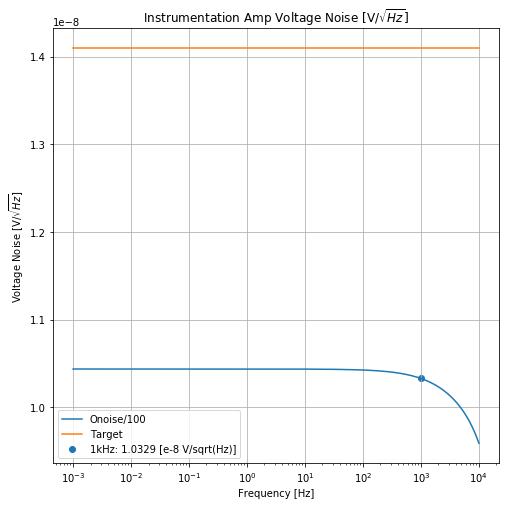

In [5]:
fig, ax = plt.subplots(1,figsize=(8,8))
#ax.semilogx(freq, mag, label='Output Noise')
ax.semilogx(freq, mag/100, label='Onoise/100')
ax.scatter(freq[x0],mag[x0]/100, label=f'1kHz: {label} [e-8 V/sqrt(Hz)]')
ax.semilogx(freq, 1.41e-8*np.ones(len(freq)), label='Target')
#ax.set_ylim(0,5e3)
#ax.set_ylim(0.9e-8,1.45e-8)
ax.ticklabel_format(style='sci', axis='y', scilimits=(-8,-8))
ax.set_title('Instrumentation Amp Voltage Noise [V/$\sqrt{Hz}$]')
ax.set_ylabel('Voltage Noise [V/$\sqrt{Hz}$]')
ax.set_xlabel('Frequency [Hz]')
ax.grid(True)
ax.legend()
plt.show();

In [6]:
filepath = 'data/ADA4528_ac.txt'
df = read_ltspice(filepath,'ac','db')
freq = df['Freq.']
mag = df['Mag_V(vout)/(V(vp)-V(vm))']
ang = df['Phase_V(vout)/(V(vp)-V(vm))']

In [7]:
#Find 1KHz Magnitude
x0 = np.where(freq<=5000)[0][-1]
mag5K = mag.iloc[x0]
label = "{:.4f}".format(mag5K)
print(f"5KHz magnitude: {label}[V/sqrt(Hz)]")
x0

5KHz magnitude: 40.0060[V/sqrt(Hz)]


669

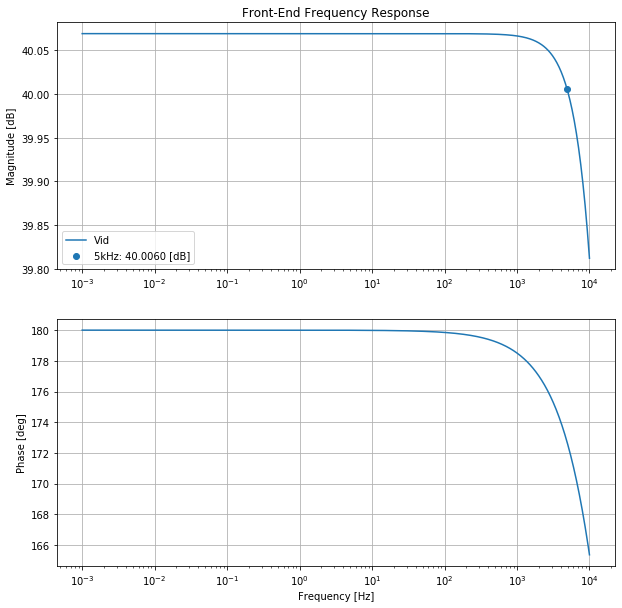

In [8]:
fig, axs = plt.subplots(2,figsize=(10,10))
axs[0].set_title('Front-End Frequency Response')
axs[0].semilogx(freq, mag, label='Vid')
axs[0].scatter(freq[x0],mag[x0], label=f'5kHz: {label} [dB]')
axs[0].set_ylabel('Magnitude [dB]')
axs[0].grid()
axs[0].legend()
axs[1].semilogx(freq, ang, label='')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Phase [deg]')
axs[1].grid()
#axs[1].legend()
plt.show();

#### Noise Calculations

In [9]:
df = pd.read_csv('data/ADIParametricSearch.csv')
df = df[1:]
df = df.drop(columns=['Package'],axis=1)
for col in df.columns:
    if col != 'Part Number':
        df[col] = pd.to_numeric(df[col])
#df['0.1 to 10 Hz VNoise (typ)'] = round(df['0.1 to 10 Hz VNoise (typ)'] ,2)
#df['VNoise Density (typ)'] = round(df['VNoise Density (typ)'],2)

In [10]:
df.head()

,Part Number,# of Amps,GBP (typ),Slew Rate (typ),VNoise Density (typ),0.1 to 10 Hz VNoise (typ),Current Noise Density (typ),Iq/Amp (typ),Vs span (min),Vs span (max),Price (1000+)
1,LT6220,1.0,60000000,20.0,1.000000e-08,5.000000e-07,8.000000e-13,0.0009,2.2,12.6,1.20
2,LT6221,2.0,60000000,20.0,1.000000e-08,5.000000e-07,8.000000e-13,0.0009,2.2,12.6,1.85
3,LT6222,4.0,60000000,20.0,1.000000e-08,5.000000e-07,8.000000e-13,0.0009,2.2,12.6,2.95
4,AD8529,2.0,8000000,2.9,1.000000e-08,5.000000e-07,4.000000e-13,0.0012,2.7,12.0,1.24
5,AD8519,1.0,8000000,2.9,1.000000e-08,5.000000e-07,4.000000e-13,0.0012,2.7,12.0,0.94


In [11]:
def noiseSolve(iN_var=1e-12,eN_var=None,flicker_var=None):
    Rgage,Rdiff1,Rdiff2,RinstF,RinstG,eN,iN,flicker = sp.symbols('R_{gage},R_{diff1},R_{diff2},R_{instF},R_{instG},eN,iN,flicker')

    k = 1.381e-23
    T=298

    Ngage = (iN*Rgage/2)**2 + (4*k*T*Rgage/2)

    Ngain = 4*k*T*RinstG*(RinstF/RinstG)**2 + \
            4*k*T*RinstF + \
            eN**2 * (1+RinstF/RinstG)**2

    Ndiffn = 4*k*T*Rdiff1*(Rdiff2/Rdiff1)**2 + \
             4*k*T*Rdiff2 + \
             eN**2 * (1+Rdiff2/Rdiff1)**2 + \
             (iN*Rdiff2)**2

    Ndiffp = 4*k*T*Rdiff2*(1+Rdiff2/Rdiff1)**2 + \
             4*k*T*Rdiff1*(1+Rdiff2/Rdiff1)**2 * (Rdiff2/(Rdiff1+Rdiff2))**2 + \
             (iN*Rdiff2)**2

    Ntotal = 2*Ngage + 2*Ngain + Ndiffn + Ndiffp
    G = 100
    Ninput = Ntotal/(G**2)
    BW = 5000

    components = {
        Rgage: 1000,
        Rdiff1: 100e3,
        Rdiff2: 100e3,
        RinstF: 49.9e3,
        RinstG: 1e3,
        #iN: 0.7e-12,
        #eN: 5.6e-9,
        #flicker: 97e-9,
    } 
    if iN_var:      components['iN'] = iN_var  
    if eN_var:      components['eN'] = eN_var
    if flicker_var: components['flicker'] = flicker_var
    H = sp.Matrix([sp.sqrt(Ninput*BW)-(1e-6-3*flicker)])
    H = H.subs(components)
    eq = sp.solve(H)
    if isinstance(eq, list):
        eq = [list(d.values()) for d in eq]
        return float(max(eq)[0])
    else: 
        return float(list(eq.values())[0])

In [12]:
def noiseTotal(iN_var=1e-12,eN_var=5.6e-9,flicker_var=97e-9):
    Rgage,Rdiff1,Rdiff2,RinstF,RinstG,eN,iN,flicker = sp.symbols('R_{gage},R_{diff1},R_{diff2},R_{instF},R_{instG},eN,iN,flicker')

    k = 1.381e-23
    T=298

    Ngage = (iN*Rgage/2)**2 + (4*k*T*Rgage/2)

    Ngain = 4*k*T*RinstG*(RinstF/RinstG)**2 + \
            4*k*T*RinstF + \
            eN**2 * (1+RinstF/RinstG)**2

    Ndiffn = 4*k*T*Rdiff1*(Rdiff2/Rdiff1)**2 + \
             4*k*T*Rdiff2 + \
             eN**2 * (1+Rdiff2/Rdiff1)**2 + \
             (iN*Rdiff2)**2

    Ndiffp = 4*k*T*Rdiff2*(1+Rdiff2/Rdiff1)**2 + \
             4*k*T*Rdiff1*(1+Rdiff2/Rdiff1)**2 * (Rdiff2/(Rdiff1+Rdiff2))**2 + \
             (iN*Rdiff2)**2

    Ntotal = 2*Ngage + 2*Ngain + Ndiffn + Ndiffp
    G = 100
    Ninput = Ntotal/(G**2)
    BW = 5000

    components = {
        Rgage: 1000,
        Rdiff1: 100e3,
        Rdiff2: 100e3,
        RinstF: 49.9e3,
        RinstG: 1e3
    }
    components['iN'] = iN_var  
    components['eN'] = eN_var
    components['flicker'] = flicker_var
    H = sp.Matrix([sp.sqrt(Ninput*BW)+flicker])
    H = H.subs(components)
    H = lambdify(flicker,H,modules='numpy')
    H = H(0)
    return H[0][0]

In [13]:
noiseTotal()

4.69681249358215e-07

In [14]:
df['Total RMS'] = df.apply(lambda row: 
    noiseTotal(
        iN_var=row['Current Noise Density (typ)'],
        eN_var=row['VNoise Density (typ)'],
        flicker_var=row['0.1 to 10 Hz VNoise (typ)']
    ), axis=1
)
DF = df[df['Total RMS']<=1e-6]

In [15]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

Cmap = cm = plt.get_cmap('Reds') 
cNorm  = colors.Normalize(vmin=0, vmax=max(DF['Price (1000+)']))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=Cmap)

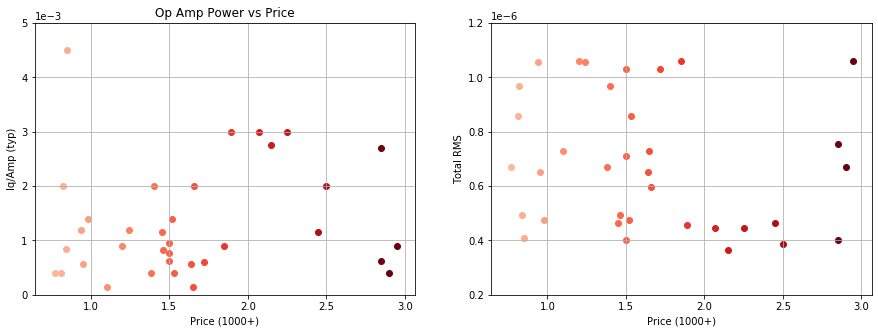

In [16]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

for i,row in df.iterrows():
    axs[0].scatter(
        row['Price (1000+)'],
        row['Iq/Amp (typ)'],
        label=row['Part Number'],
        color=scalarMap.to_rgba(row['Price (1000+)'])
    )
axs[0].set_ylim(0,5e-3)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(-3,-3))
axs[0].set_xlabel('Price (1000+)')
axs[0].set_ylabel('Iq/Amp (typ)')
axs[0].set_title('Op Amp Power vs Price')
axs[0].grid(axis='both')

for i,row in df.iterrows():
    axs[1].scatter(
        row['Price (1000+)'],
        row['Total RMS'],
        label=row['Part Number'],
        color=scalarMap.to_rgba(row['Price (1000+)'])
    )
axs[1].set_ylim(0.2e-6,1.2e-6)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
axs[1].set_xlabel('Price (1000+)')
axs[1].set_ylabel('Total RMS')
axs[1].grid(axis='both')


#axs[1].legend()
plt.show();

In [17]:
eN_arr = np.linspace(0.5e-9,18e-9,36)
flicker_arr = [noiseSolve(eN_var=eN) for eN in eN_arr]

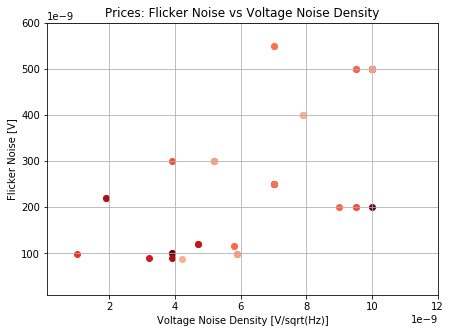

In [19]:
fig, ax = plt.subplots(figsize=(7,5))

#ax.plot(eN_arr,flicker_arr)
#ax.fill_between(eN_arr,0,flicker_arr)
for i,row in df.iterrows():
    ax.scatter(
        row['VNoise Density (typ)'],
        row['0.1 to 10 Hz VNoise (typ)'],
        label=row['Part Number'],
        color=scalarMap.to_rgba(row['Price (1000+)'])
    )
ax.set_ylim(.1e-7,6e-7)
ax.set_xlim(.1e-9,12e-9)
ax.ticklabel_format(style='sci', axis='x', scilimits=(-9,-9))
ax.ticklabel_format(style='sci', axis='y', scilimits=(-9,-9))
ax.set_xlabel('Voltage Noise Density [V/sqrt(Hz)]')
ax.set_ylabel('Flicker Noise [V]')
ax.set_title('Prices: Flicker Noise vs Voltage Noise Density')
ax.grid(axis='both')
#ax.legend()
plt.show();

#### ADC Driver

$\begin{eqnarray}
&& f_{3dB} &=& \beta f_{T}\Bigg|_{\beta = 1} &=& f_{T}\\[0.5em]
&& t_{\text{settle}} &\geq& \ln{0.0001}  &\rightarrow& 5 \mu s \geq 6.9 \tau \\[0.5em]
&& \tau_{CL} &=& \frac{1}{2\pi f_{3dB}} &=& \frac{1}{2\pi f_{T}} \\[0.5em]
&& \frac{5 \mu s}{6.9} &\geq&  \frac{1}{2\pi f_{T}} \\[0.5em]
&& f_{T} &\geq& 219,634 \text{ Hz}
\end{eqnarray}$

<hr>

#### Filter Design

<img src="images/SallenKeyHP.png" width="400">

In [20]:
s,m,n,C1,C2,R1,R2,Q,tau,W0,Wc,Cn,K = sp.symbols('s,m,n,C1,C2,R1,R2,Q,tau,omega0,Wc,Cn,K')

In [21]:
# High Pass ChebyShev
fc1 = 1/3.4
systemHP = sp.Matrix([
    [W0 - 1/(tau*sp.sqrt(m*n))],
    [W0 - Wc/Cn],
    [Q - sp.sqrt(m*n)/(1+n)],
    [m - R1/R2],
    [n - C2/C1],
    [tau - R1*C2]
])
myVals = {
    W0:2*sp.pi*fc1,    # 1Hz
    Cn:1.0500,       # Table 
    Q:0.9565,        # Table 
    n:1,             # Chosen Ratio 
    C2:1e-6         # Chosen Value 
}
systemHP = systemHP.subs(myVals)
eq = sp.solve(systemHP)
eq, myVals

([{C1: 1.00000000000000e-6,
   R1: 282868.168589882,
   R2: 77295.4871433991,
   Wc: 1.94039546251134,
   m: 3.65956900000000,
   tau: 0.282868168589882}],
 {omega0: 0.588235294117647*pi, Cn: 1.05, Q: 0.9565, n: 1, C2: 1e-06})

In [22]:
f = np.logspace(-2, 4, 10000)
w = 2*np.pi*f
#s = 1j*w

num = 1*s**2
a = 1
b = (1/R1)*(C1+C2)/(C1*C2)
c = 1/(R1*R2*C1*C2)
den = a*s**2 + b*s + c

components = {
    C1:1e-6,
    C2:1e-6,
    R1:282868.168589882,
    R2:77295.4871433991
}
H = sp.Matrix([num/den])
H1 = H = H.subs(components)
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]

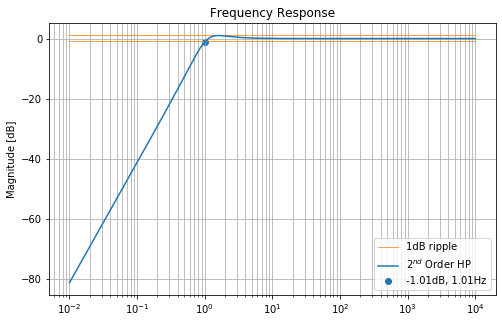

In [23]:
fig, ax = plt.subplots(figsize=(8,5))

x1 = np.where(20*np.log10(abs(H))<=-1)[0][-1]
label1 = "{:.2f}dB, {:.2f}Hz".format(20*np.log10(abs(H[x1])),f[x1])

ax.set_title('Frequency Response')
ax.semilogx(f, 1*np.ones(len(H)),color='tab:orange',linewidth=.75)
ax.semilogx(f,-1*np.ones(len(H)),color='tab:orange',linewidth=.75,label='1dB ripple')
ax.semilogx(f, 20*np.log10(abs(H)),label=r'$2^{nd}$ Order HP')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

<img src="images/SallenKeyLP.png" width="400">

In [24]:
s,m,n,C1,C2,R1,R2,Q,tau,W0,Wc,Cn,K = sp.symbols('s,m,n,C1,C2,R1,R2,Q,tau,omega0,Wc,Cn,K')

In [25]:
# Low Pass ChebyShev
fc1 = 5e3/1.08
systemLP = sp.Matrix([
    [W0 - 1/(tau*sp.sqrt(m*n))],
    [W0 - Cn*Wc],
    [Q - sp.sqrt(m*n)/(1+m)],
    [m - R1/R2],
    [n - C2/C1],
    [tau - R2*C1]
])
myVals = {
    W0:2*sp.pi*fc1,  # 5KHz
    Cn:1.0500,       # Table 
    Q:0.9565,        # Table 
    m:1,             # Chosen Ratio 
    C2:10e-9         # Chosen Value 
}
systemLP = systemLP.subs(myVals)
eq = sp.solve(systemLP)
eq, myVals

([{C1: 2.73256222249123e-9,
   R1: 6576.40957251159,
   R2: 6576.40957251159,
   Wc: 27703.6389205449,
   n: 3.65956900000000,
   tau: 1.79704483574749e-5}],
 {omega0: 9259.25925925926*pi, Cn: 1.05, Q: 0.9565, m: 1, C2: 1e-08})

In [26]:
f = np.logspace(1, 5, 10000)
w = 2*np.pi*f
#s = 1j*w

num = 1/(R1*R2*C1*C2)
a = 1
b = (1/C2)*(R1+R2)/(R1*R2)
c = 1/(R1*R2*C1*C2)
den = a*s**2 + b*s + c

components = {
    C1:2.73256222249123e-9,
    C2:10e-9,
    R1:6454,
    R2:6454
}
H = sp.Matrix([num/den])
H2 = H = H.subs(components)
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]

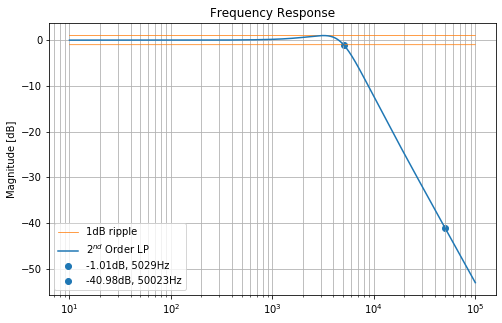

In [27]:
fig, ax = plt.subplots(figsize=(8,5))

x1 = np.where(20*np.log10(abs(H))<=-1)[0][0]
label1 = "{:.2f}dB, {:.0f}Hz".format(20*np.log10(abs(H[x1])),f[x1])
x2 = np.where(f>=50000)[0][0]
label2 = "{:.2f}dB, {:.0f}Hz".format(20*np.log10(abs(H[x2])),f[x2])

ax.set_title('Frequency Response')
ax.semilogx(f, 1*np.ones(len(H)),color='tab:orange',linewidth=.75)
ax.semilogx(f,-1*np.ones(len(H)),color='tab:orange',linewidth=.75,label='1dB ripple')
ax.semilogx(f, 20*np.log10(abs(H)),label=r'$2^{nd}$ Order LP')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.scatter(f[x2],20*np.log10(abs(H[x2])),label=label2,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

<hr>

In [28]:
f = np.logspace(-1, 5, 100000)
w = 2*np.pi*f
H = H1 * H2
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]

/home/kegedy/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


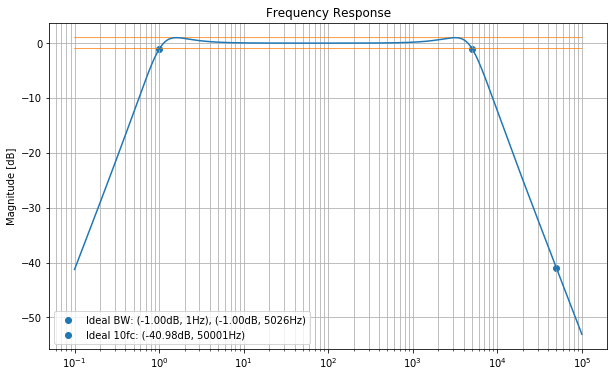

In [29]:
fig, ax = plt.subplots(figsize=(10,6))

x0 = np.where(20*np.log10(abs(H[0:20000]))<=-1)[0][-1]
label0 = "({:.2f}dB, {:.0f}Hz)".format(20*np.log10(abs(H[x0])),f[x0])
x1 = 20000+np.where(20*np.log10(abs(H[20000:]))<=-1)[0][0]
label1 = "({:.2f}dB, {:.0f}Hz)".format(20*np.log10(abs(H[x1])),f[x1])
label1 = "Ideal BW: " + label0 + ", " + label1
x2 = np.where(f>=50000)[0][0]
label2 = "({:.2f}dB, {:.0f}Hz)".format(20*np.log10(abs(H[x2])),f[x2])
label2 = "Ideal 10fc: " + label2

ax.set_title('Frequency Response')
ax.semilogx(f, 1*np.ones(len(H)),color='tab:orange',linewidth=.75)
ax.semilogx(f,-1*np.ones(len(H)),color='tab:orange',linewidth=.75) #,label='1dB ripple')
ax.semilogx(f, 20*np.log10(abs(H))) #,label=r'$4^{th}$ Order Sallen-Key BP')
ax.scatter(f[x0],20*np.log10(abs(H[x0])),color='tab:blue')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.scatter(f[x2],20*np.log10(abs(H[x2])),label=label2,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();